<a href="https://colab.research.google.com/github/Ivansatriop/Machine-Learning/blob/main/Linear_data_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deklarasi yang perlu 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%matplotlib inline



Input file 

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

##Data Preprocessing

In [7]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8c6b7ff90>,
      dtype=object)

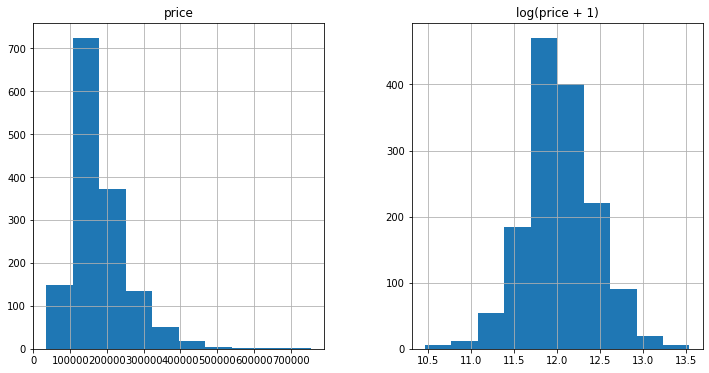

In [8]:
prices = pd.DataFrame({"price":train['SalePrice'], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

merubah nilai sale price pada train jadi nilai sale price train log1p

In [9]:
train["SalePrice"] = np.log1p(train["SalePrice"])

log transformed skewed numeric features

In [11]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = train[numeric_feats].apply(lambda x:skew(x. dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

In [12]:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [13]:
all_data = pd.get_dummies(all_data)

Filling NA dengan mean pada kolom data

In [14]:
all_data = all_data.fillna(all_data.mean())

membuat matrices untuk sklearn 

In [15]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

##Model ML Linear

In [26]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [27]:
def rmse_cv(model):
  rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv = 5 ))
  return(rmse)

In [28]:
model_ridge = Ridge()

pada model ridge, nilai alpha berperan dalam menentukan seberapa flexible model kita, semakin tinggi regulasinya akan lebih kecil kemungkinan model kita akan overfitting

In [29]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 13, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]

Text(0, 0.5, 'rmse')

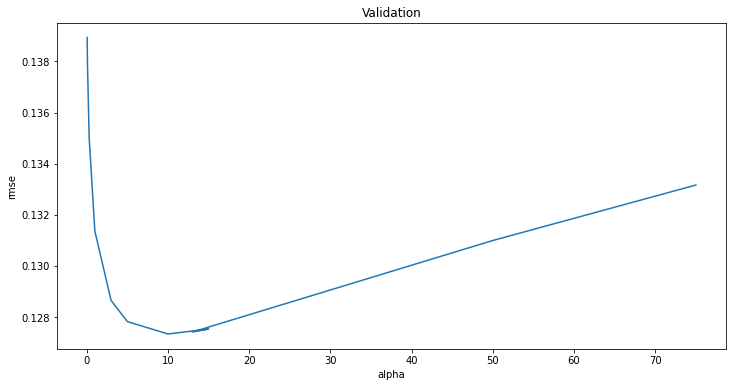

In [30]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = 'Validation')
plt.xlabel('alpha')
plt.ylabel('rmse')

In [31]:
cv_ridge.min()
#hasil menggunakan metode ridge adalah sebagai berikut

0.1273373466867076

##Lasso model

In [33]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train,y)

In [34]:
rmse_cv(model_lasso).mean()
#hasil menggunakan metode lasso, lebih baik dari pada metode ridge

0.12256735885048142

Lasso Selection features

In [36]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [40]:
print('Lasso Picked ' + str(sum(coef != 0))+ ' variables and eliminated the other ' + str(sum(coef == 0)) + ' variables')

Lasso Picked 110 variables and eliminated the other 178 variables


important coeficient

In [43]:
imp_coef = pd.concat([coef.sort_values().head(10),
                      coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficient in Lasso Model')

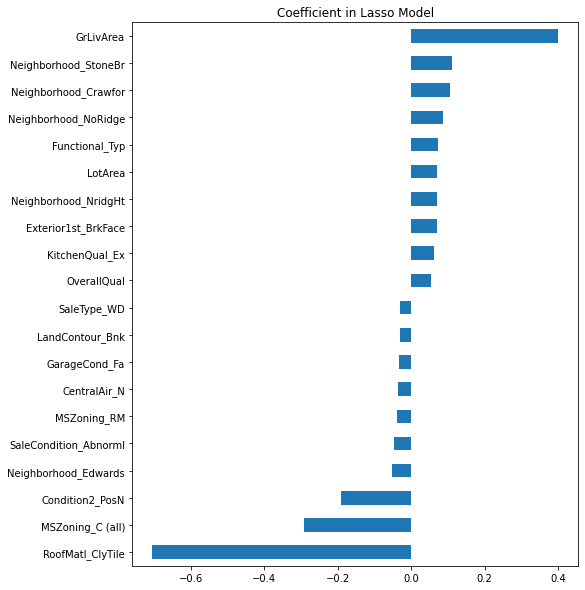

In [45]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = 'barh')
plt.title('Coefficient in Lasso Model')

melihat dalam bentuk residual

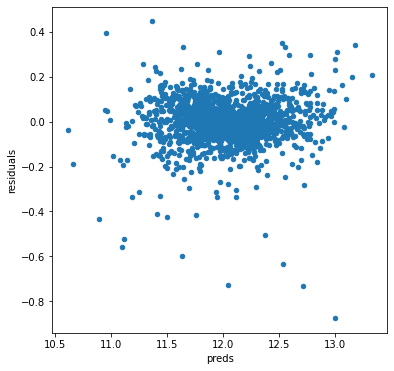

In [51]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds', y = 'residuals', kind = 'scatter')

##xboost model

In [53]:
import xgboost as xgb

In [54]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {'max+depth':2, 'eta': 0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

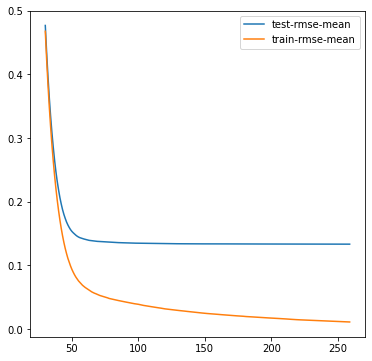

In [59]:
model.loc[30:,['test-rmse-mean', 'train-rmse-mean']].plot()

In [62]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

[08:07:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [66]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

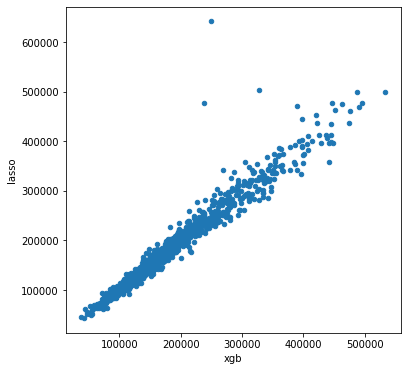

In [67]:
predictions = pd.DataFrame({"xgb": xgb_preds, "lasso":lasso_preds})
predictions.plot(x = 'xgb', y = 'lasso', kind = 'scatter')

In [68]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [94]:
solution = pd.DataFrame({'id':test.Id, 'SalePrice':preds})
solution.to_csv('ridge_sol.csv', index = False)

##Using Keras

In [107]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [108]:
X_train = StandardScaler().fit_transform(X_train)

In [109]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [110]:
X_tr.shape

(1095, 288)

In [111]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [114]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], kernel_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")


In [137]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [138]:
hist = model.fit(
    X_tr, 
    y_tr, 
    epochs = 10,
    steps_per_epoch = 1095,
    validation_steps = 5,
    validation_data = (X_val, y_val) 
    )

Epoch 1/10
1095/1095 [==============================] - 2s 2ms/step - loss: 0.1356 - val_loss: 3207.8259
Epoch 2/10
1095/1095 [==============================] - 2s 2ms/step - loss: 0.1389 - val_loss: 3174.7698
Epoch 3/10
1095/1095 [==============================] - 2s 2ms/step - loss: 0.1316 - val_loss: 3121.4692
Epoch 4/10
1095/1095 [==============================] - 2s 2ms/step - loss: 0.1330 - val_loss: 3080.6848
Epoch 5/10
1095/1095 [==============================] - 2s 2ms/step - loss: 0.1395 - val_loss: 3026.5740
Epoch 6/10
1095/1095 [==============================] - 2s 2ms/step - loss: 0.1327 - val_loss: 2985.3467
Epoch 7/10
1095/1095 [==============================] - 2s 2ms/step - loss: 0.1347 - val_loss: 2929.4624
Epoch 8/10
1095/1095 [==============================] - 2s 2ms/step - loss: 0.1282 - val_loss: 2893.0508
Epoch 9/10
1095/1095 [==============================] - 2s 2ms/step - loss: 0.1270 - val_loss: 2845.6731
Epoch 10/10
1095/1095 [==============================] 

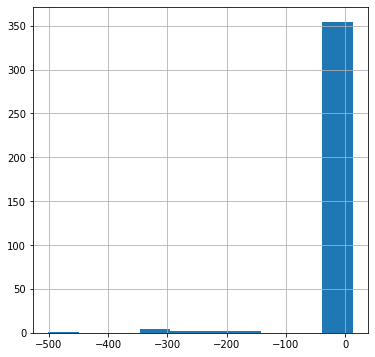

In [139]:
pd.Series(model.predict(X_val)[:,0]).hist()